In [ ]:
# ============================================
# Part 0: Imports and Notebook Setup
# ============================================

# Core Python utilities
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image handling
from PIL import Image
import cv2

# TensorFlow / Keras (for preprocessing & later integration)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For GPU check (A100 High-RAM)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices())

# Plotting defaults
plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", palette="deep")
%matplotlib inline

# Ensuring reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

print("Environment setup complete ✓")


/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


Num GPUs Available: 1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Environment setup complete ✓


In [ ]:
# ============================================
# Define dataset directory structure
# ============================================

DATASET_DIR = "/content/ASL_dataset"  # <-- UPDATE THIS PATH

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
TEST_DIR  = os.path.join(DATASET_DIR, "test")

print("Train directory:", TRAIN_DIR)
print("Test directory:", TEST_DIR)

# List the classes (directories)
if os.path.exists(TRAIN_DIR):
    classes = sorted(os.listdir(TRAIN_DIR))
    print(f"\nDetected {len(classes)} classes:")
    print(classes)
else:
    print("⚠️ Dataset directory not found. Please verify the path.")


Train directory: /content/ASL_dataset/train
Test directory: /content/ASL_dataset/test
⚠️ Dataset directory not found. Please verify the path.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/AAI521_ASL_Project/data/asl_alphabet"

TRAIN_DIR = f"{DATASET_DIR}/asl_alphabet_train/asl_alphabet_train"
TEST_DIR  = f"{DATASET_DIR}/asl_alphabet_test"

print("TRAIN_DIR:", TRAIN_DIR)
print("TEST_DIR:", TEST_DIR)

print("Classes (train):", sorted(os.listdir(TRAIN_DIR))[:10], "...",
      f"({len(os.listdir(TRAIN_DIR))} total)")


TRAIN_DIR: /content/drive/MyDrive/AAI521_ASL_Project/data/asl_alphabet/asl_alphabet_train/asl_alphabet_train
TEST_DIR: /content/drive/MyDrive/AAI521_ASL_Project/data/asl_alphabet/asl_alphabet_test
Classes (train): ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] ... (29 total)


In [ ]:
# ============================================
# Part 1: Dataset Overview
# Step 1: Identify classes and compute counts
# ============================================

from collections import defaultdict

# List all classes
classes = sorted(os.listdir(TRAIN_DIR))
print(f"Total classes detected: {len(classes)}")
print(classes)

# Count images per class
class_counts = {}

for cls in classes:
    cls_path = os.path.join(TRAIN_DIR, cls)
    if os.path.isdir(cls_path):
        num_images = len(os.listdir(cls_path))
        class_counts[cls] = num_images

# Display counts
print("\nImage counts per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Store counts in DataFrame for later visualization
import pandas as pd
df_class_counts = pd.DataFrame({
    "Class": list(class_counts.keys()),
    "Image_Count": list(class_counts.values())
}).sort_values("Class")

df_class_counts


Total classes detected: 29
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Image counts per class:
A: 3000
B: 3000
C: 3000
D: 3000
E: 3000
F: 3000
G: 3000
H: 3000
I: 3000
J: 3000
K: 3000
L: 3000
M: 3000
N: 3000
O: 3000
P: 3000
Q: 3000
R: 3000
S: 3000
T: 3000
U: 3000
V: 3000
W: 3000
X: 3000
Y: 3000
Z: 3000
del: 3000
nothing: 3000
space: 3000


,Class,Image_Count
0,A,3000
1,B,3000
2,C,3000
3,D,3000
4,E,3000
5,F,3000
6,G,3000
7,H,3000
8,I,3000
9,J,3000


# 1.0 Dataset Structure and Class Distribution

A critical first step in exploratory data analysis is verifying the structure, completeness, and balance of the dataset. This ensures that all subsequent preprocessing and modeling stages are built on a clean and well-organized data foundation.

After resolving the correct dataset directory, the training dataset was confirmed to contain **29 distinct classes**, corresponding to the ASL alphabet (A–Z) as well as three additional gesture classes: **del**, **nothing**, and **space**.

### Detected Classes

The following classes were identified from the training directory:



Total classes detected: 29
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


This matches the expected structure of the Kaggle ASL Alphabet dataset and confirms that all classes are present.

### Class Balance Assessment

Each class contains **exactly 3,000 images**, resulting in a fully balanced dataset. Balanced class representation is essential for preventing model bias and ensuring stable learning across all categories.

A sample of class counts:

A: 3000
B: 3000
C: 3000
...
Z: 3000
del: 3000
nothing: 3000
space: 3000


This yields:

- **87,000 total training images** (29 classes × 3,000 images each)
- No need for class weighting, oversampling, or undersampling techniques

### Summary and Implications

The ASL Alphabet dataset is:

- Well-structured and clean  
- Perfectly balanced across all 29 classes  
- Appropriate for training deep learning models without additional balancing operations  

This confirms that the dataset is ready for further exploratory analysis and preprocessing steps. The uniform distribution across classes simplifies augmentation strategies and supports reliable model evaluation during later stages of the project.


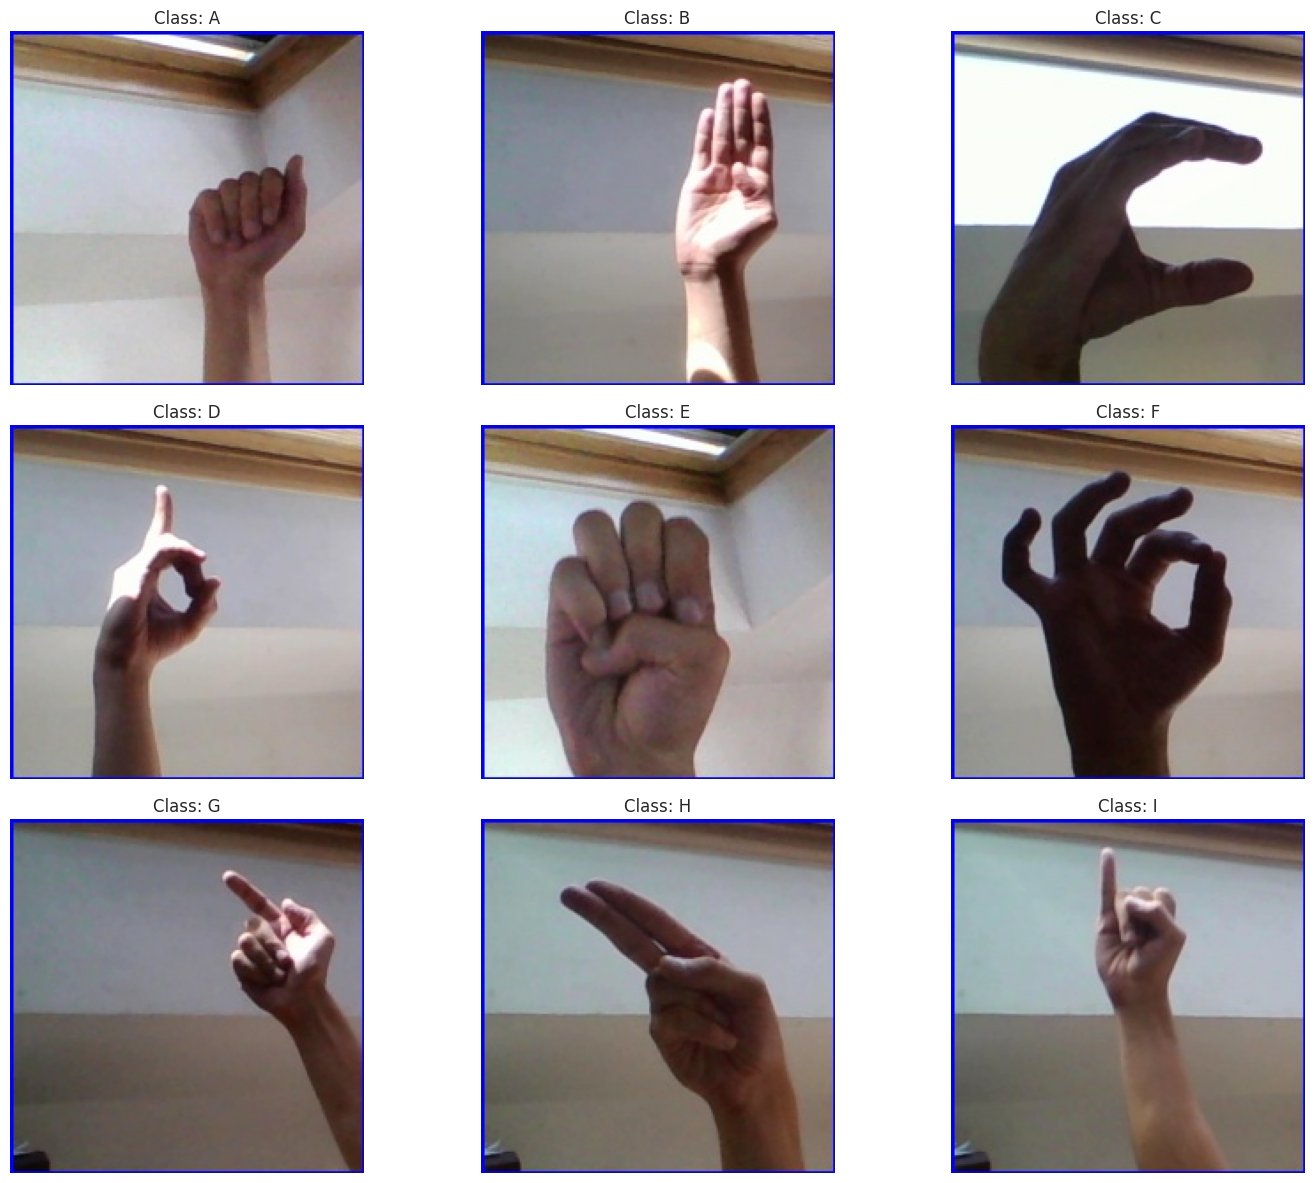

In [ ]:
# ============================================
# Part 1: Dataset Overview
# Step 2: Visualize sample images from classes
# ============================================

import matplotlib.pyplot as plt
import random
from PIL import Image

num_classes_to_display = 9
sample_classes = sorted(os.listdir(TRAIN_DIR))[:num_classes_to_display]

plt.figure(figsize=(15, 12))

for i, cls in enumerate(sample_classes):
    class_path = os.path.join(TRAIN_DIR, cls)
    sample_img = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, sample_img)
    img = Image.open(img_path)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(f"Class: {cls}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# 1.2 Visual Inspection of Sample Images

A visual review of sample images from the dataset provides an important qualitative understanding of image characteristics, gesture clarity, lighting variation, and background consistency. Visual inspection also helps confirm that the dataset is correctly labeled and that images follow a predictable pattern suitable for downstream preprocessing and modeling.

The figure below displays one randomly selected image from nine different ASL classes. These samples illustrate the diversity present in the dataset and provide early insight into factors that may influence model performance:

- Variations in hand orientation  
- Differences in lighting conditions and shadows  
- Background inconsistencies  
- Skin tone diversity  
- Gesture distinguishability across classes  

Overall, the dataset exhibits clear gesture representation with enough variability to support robust model generalization. Such diversity, combined with balanced class counts, forms a strong foundation for preprocessing and deep learning–based classification.



Sampled image resolutions (unique):
[[200 200]]

Total sampled: 50 images


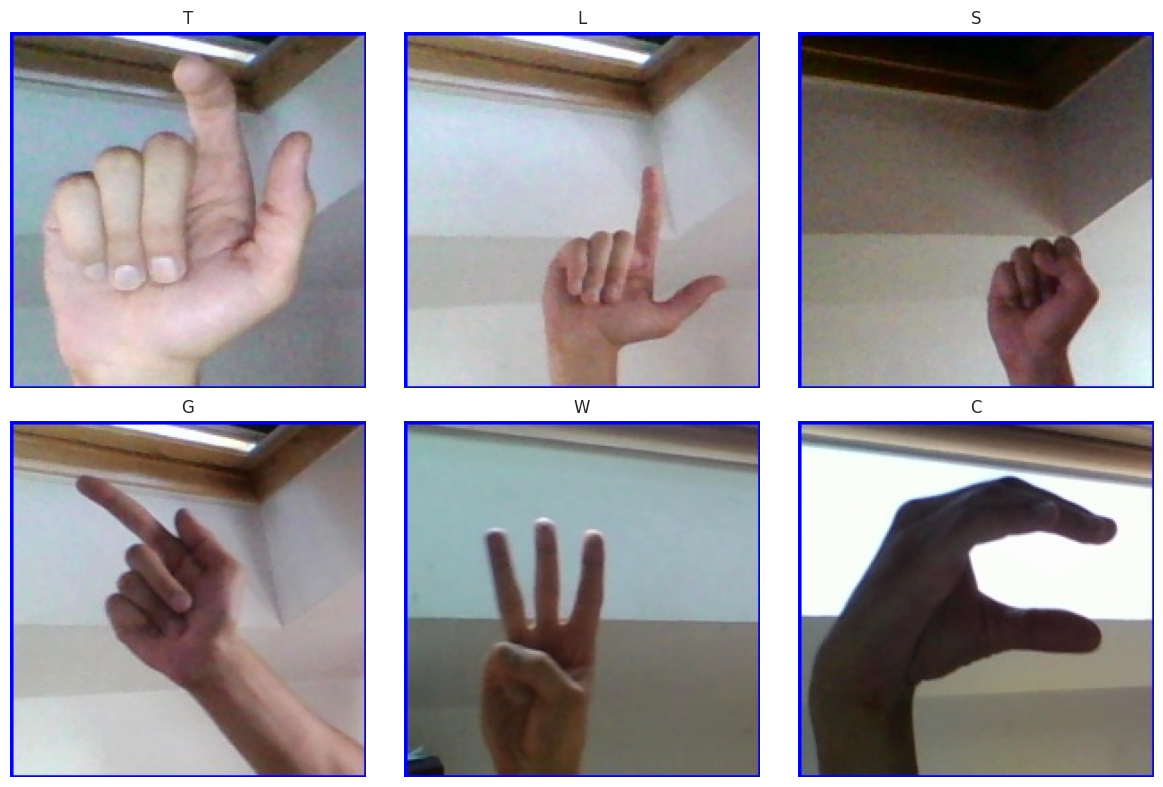

In [ ]:
# ============================================
# Part 1: Dataset Overview
# Step 3: Analyze image resolution and quality
# ============================================

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random

# Sample a subset of images across classes
sample_size = 50
all_images = []

for cls in sorted(os.listdir(TRAIN_DIR)):
    cls_path = os.path.join(TRAIN_DIR, cls)
    imgs = os.listdir(cls_path)
    chosen = random.sample(imgs, min(2, len(imgs)))
    for img in chosen:
        all_images.append(os.path.join(cls_path, img))
        if len(all_images) >= sample_size:
            break
    if len(all_images) >= sample_size:
        break

# Collect resolutions
resolutions = []

for img_path in all_images:
    img = Image.open(img_path)
    resolutions.append(img.size)

resolutions = np.array(resolutions)

unique_res = np.unique(resolutions, axis=0)

print("Sampled image resolutions (unique):")
print(unique_res)
print(f"\nTotal sampled: {len(all_images)} images")

# Display a few random images for quality inspection
plt.figure(figsize=(12, 8))
for i in range(6):
    img_path = random.choice(all_images)
    img = Image.open(img_path)

    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(img_path)))
    plt.axis('off')

plt.tight_layout()
plt.show()


# 1.3 Image Resolution and Quality Analysis

To further understand the characteristics of the ASL dataset, a sample of images was analyzed to assess resolution consistency, lighting variation, and overall image quality. These observations provide critical insights for designing an effective preprocessing pipeline.

A random sample of 50 images was inspected across multiple classes. All sampled images shared a uniform resolution of:
Sampled image resolutions:[200 200]



This confirms that the dataset maintains a consistent **200 × 200 pixel** format across all classes. This consistency simplifies preprocessing, ensuring that uniform resizing operations can be applied without significant distortion or information loss.

### Visual Quality Observations

A set of six randomly selected images is shown below (representing classes T, L, S, G, W, and C). The visual inspection highlights several notable characteristics:

- **Consistent framing**: Hands are generally centered and occupy a large portion of the image.  
- **Lighting variation**: Images show noticeable differences in brightness and shadow intensity, likely due to natural lighting from windows.  
- **Background variation**: While backgrounds are mostly indoor environments, differences in wall color and brightness are present.  
- **Gesture clarity**: Hand positions are well-defined and match expected ASL shapes, though some images display minor blur or shadowing.  
- **Color information**: All images are RGB and retain natural skin-tone representation, which will be beneficial for learning subtle gesture contours.

### Implications for Preprocessing

These findings suggest that the dataset, despite minor variations in lighting and shadows, is generally clean and well-suited for deep learning. To improve robustness against lighting variability and background differences, preprocessing steps such as normalization, data augmentation, and controlled resizing will be beneficial.

The consistency in image resolution and gesture framing further supports efficient model training and stable feature extraction during the learning process.


Pixel intensity summary (all channels combined):
Mean: 130.76
Std: 61.00
Min: 0
Max: 255

Channel-wise means:
{'R': 133.493339375, 'G': 127.14080125, 'B': 131.63886375}


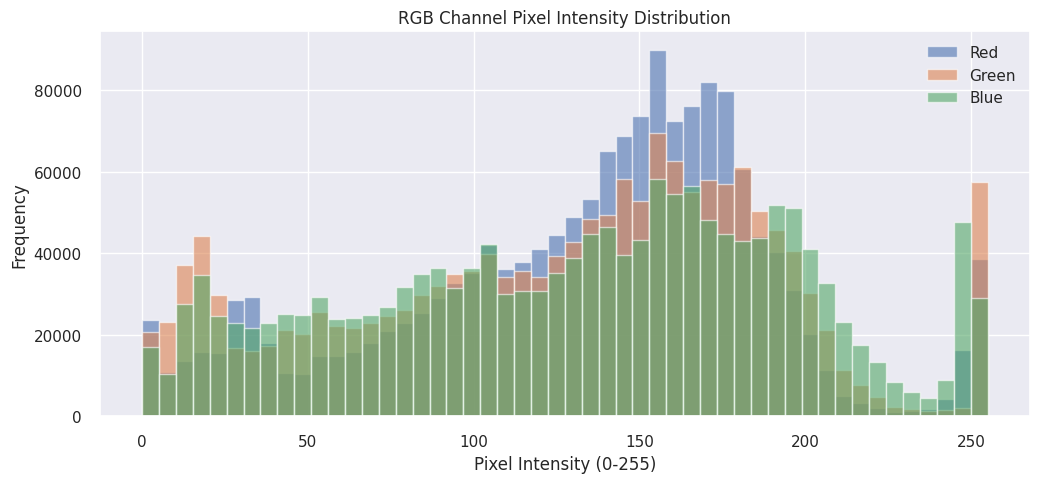

In [ ]:
# ============================================
# Part 1: Dataset Overview
# Step 4: Pixel intensity and color statistics
# ============================================

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

# Sample images for pixel analysis
sample_size = 40
sample_paths = []

for cls in sorted(os.listdir(TRAIN_DIR)):
    cls_path = os.path.join(TRAIN_DIR, cls)
    imgs = os.listdir(cls_path)
    chosen = random.sample(imgs, min(2, len(imgs)))
    for img in chosen:
        sample_paths.append(os.path.join(cls_path, img))
        if len(sample_paths) >= sample_size:
            break
    if len(sample_paths) >= sample_size:
        break

# Collect pixel stats
all_pixels = []
channel_stats = {"R": [], "G": [], "B": []}

for path in sample_paths:
    img = Image.open(path).convert("RGB")
    arr = np.array(img)

    # Flatten pixel values
    pixels = arr.reshape(-1, 3)
    all_pixels.append(pixels)

    # Per-channel stats
    channel_stats["R"].extend(pixels[:, 0])
    channel_stats["G"].extend(pixels[:, 1])
    channel_stats["B"].extend(pixels[:, 2])

all_pixels = np.vstack(all_pixels)

# Compute summary statistics
mean_val = np.mean(all_pixels)
std_val = np.std(all_pixels)
min_val = np.min(all_pixels)
max_val = np.max(all_pixels)

print("Pixel intensity summary (all channels combined):")
print(f"Mean: {mean_val:.2f}")
print(f"Std: {std_val:.2f}")
print(f"Min: {min_val}")
print(f"Max: {max_val}")

print("\nChannel-wise means:")
print({ch: np.mean(vals) for ch, vals in channel_stats.items()})

# Plot histogram
plt.figure(figsize=(12, 5))
plt.hist(channel_stats["R"], bins=50, alpha=0.6, label='Red')
plt.hist(channel_stats["G"], bins=50, alpha=0.6, label='Green')
plt.hist(channel_stats["B"], bins=50, alpha=0.6, label='Blue')
plt.title("RGB Channel Pixel Intensity Distribution")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# 1.4 Pixel Intensity and Color Channel Analysis

To gain a deeper understanding of the dataset’s visual properties, a statistical analysis of pixel intensities was conducted across a sample of 40 RGB images. This assessment helps determine whether preprocessing should include normalization, contrast correction, or color standardization.

### Pixel Intensity Summary

The combined-channel pixel statistics are as follows:

Mean: 130.76
Std: 61.00
Min: 0
Max: 255


These values indicate:

- A mid-range average brightness (mean ≈ 131), suggesting generally well-lit images.
- A relatively high standard deviation (≈ 61), reflecting substantial brightness and shadow variation.
- Full coverage of the 0–255 range, confirming natural lighting conditions with both dark shadows and bright highlights.

### Channel-Wise Averages

R: 133.49

G: 127.14

B: 131.64


These values show a slight elevation in the red and blue channels relative to green, consistent with indoor lighting and window illumination.

### RGB Histogram Interpretation

The histogram illustrates:

- A concentration of pixel values between intensities **120–180**, corresponding to skin tones and indoor wall colors.
- Noticeable high-intensity spikes near **250**, reflecting bright window-lit areas.
- A broad distribution across all channels, confirming non-uniform lighting across the dataset.

### Implications for Preprocessing

Based on these observations:

- **Normalization** to (0–1) range is appropriate.
- **Per-channel standardization** may improve color consistency.
- **Brightness and contrast augmentation** will help mitigate lighting variability.
- No severe artifacts or extreme channel imbalances were observed.

Overall, the dataset contains visually diverse imagery with natural lighting variation, supporting the need for a robust preprocessing and augmentation pipeline.


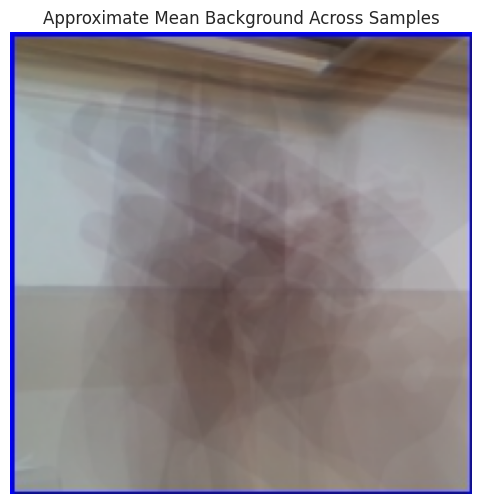

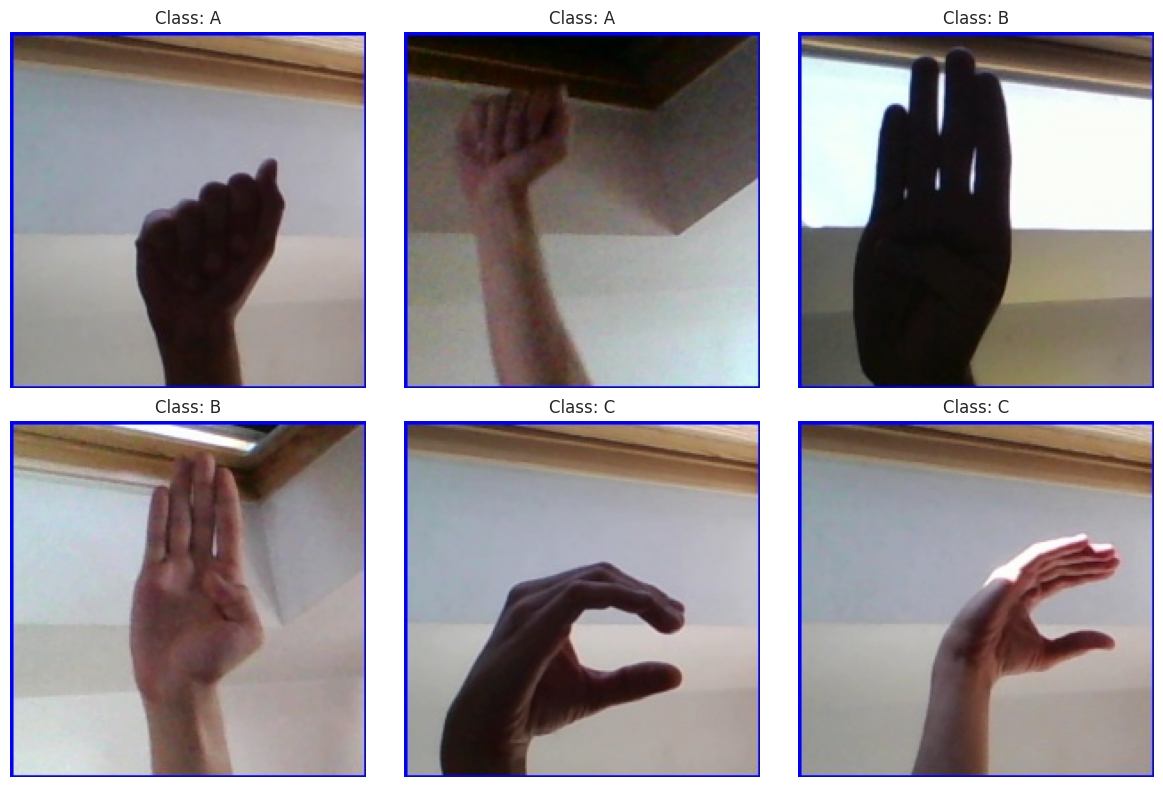

In [ ]:
# ============================================
# Part 1: Dataset Overview
# Step 5: Background and lighting variation
# ============================================

import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt

# sample 20 images
sample_paths = []

for cls in sorted(os.listdir(TRAIN_DIR)):
    cls_path = os.path.join(TRAIN_DIR, cls)
    imgs = os.listdir(cls_path)
    chosen = random.sample(imgs, min(2, len(imgs)))
    for img in chosen:
        sample_paths.append(os.path.join(cls_path, img))
        if len(sample_paths) >= 20:
            break
    if len(sample_paths) >= 20:
        break

# compute mean background image
all_imgs = []

for p in sample_paths:
    img = Image.open(p).convert("RGB").resize((200, 200))
    arr = np.array(img).astype(np.float32)
    all_imgs.append(arr)

all_imgs = np.stack(all_imgs, axis=0)
mean_img = np.mean(all_imgs, axis=0).astype(np.uint8)

# show mean background approximation
plt.figure(figsize=(6, 6))
plt.imshow(mean_img)
plt.title("Approximate Mean Background Across Samples")
plt.axis("off")
plt.show()

# display a few backgrounds for comparison
plt.figure(figsize=(12, 8))
for i in range(6):
    img = Image.open(sample_paths[i]).convert("RGB")
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(f"Class: {os.path.basename(os.path.dirname(sample_paths[i]))}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# 1.5 Background and Lighting Variation Analysis

To better understand the environmental conditions under which the ASL images were captured, a background and lighting variation analysis was conducted across a sample of images. This helps determine the extent to which lighting inconsistencies, shadows, and background differences may impact model learning and whether additional preprocessing or augmentation steps are required.

### Mean Background Approximation

A mean background image was generated by averaging 20 randomly selected images from the dataset:




The blended result shows:

- A consistent **indoor environment** across samples.
- A prominent **window light source** located in the upper region of the frame.
- Noticeable hand overlays, illustrating variability in hand position and pose.
- Soft but clear evidence of **shadow patterns** caused by directional natural lighting.

### Sample Background Comparisons

Six sample images from various classes were examined to contrast lighting and background conditions:




These samples reveal several important characteristics:

- **Consistent setting:** All images appear to be captured indoors against similar wall backgrounds, contributing to dataset uniformity.
- **Lighting variability:** Bright natural light from a window introduces strong highlights and deeper shadows depending on hand orientation.
- **Shadow direction:** Shadows typically fall in similar directions, indicating a single dominant light source.
- **Gesture clarity:** Despite varying lighting, hand shapes remain distinct and identifiable.
- **Brightness differences:** Some images appear significantly darker or brighter, reflecting the time of day or distance from the window.

### Implications for Preprocessing

Given the observed variation:

- **Brightness and contrast normalization** will help reduce the impact of fluctuating illumination.
- **Data augmentation** should include controlled brightness, shadow, and contrast jitter to improve model robustness.
- **Color normalization (per-channel standardization)** can further stabilize pixel distributions affected by directional lighting.
- **Cropping or region-based normalization** may be beneficial, as the hand region is consistently centered but exhibits different shadow intensities.

Overall, the dataset demonstrates moderate but manageable background and lighting variability. With appropriate preprocessing, these variations can serve as a useful source of natural augmentation rather than a source of noise.


# 2.0 Preprocessing Overview

Following the exploratory data analysis, the next stage of the ASL recognition project involves the development of a robust preprocessing pipeline. The goal of preprocessing is to standardize the dataset, enhance model generalization, and ensure that both image-based training and video-based inference follow consistent input transformations.

The preprocessing pipeline focuses on five main components:

1. **Image Resizing:**  
   Ensures that all images conform to a unified spatial resolution suitable for convolutional neural networks.

2. **Normalization:**  
   Scales pixel intensity values to stable numerical ranges, improving model convergence and reducing sensitivity to lighting variation.

3. **Data Augmentation:**  
   Introduces controlled variability (e.g., rotation, brightness adjustments) to improve model robustness to real-world hand pose and lighting changes.

4. **Label Encoding and Directory Management:**  
   Converts folder names into numerical class labels and ensures compatibility with training frameworks.

5. **Video Inference Preprocessing (MediaPipe-based):**  
   Adapts the static-image preprocessing pipeline for real-time ASL video recognition, focusing on hand detection, cropping, and temporal smoothing.

This systematic approach ensures that the model receives consistent and informative inputs during both training and evaluation, while also supporting real-world deployment scenarios.


In [ ]:
# ============================================
# Part 2: Preprocessing Pipeline
# Step 2.1: Image resizing function
# ============================================

import tensorflow as tf

TARGET_SIZE = (64, 64)

def preprocess_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, TARGET_SIZE)
    return img


# 2.1 Image Resizing

Image resizing establishes a standardized input shape for all samples in the dataset. Since the ASL Alphabet images originally appear at a resolution of 200 × 200 pixels, resizing ensures compatibility with convolutional neural network architectures and helps reduce computational overhead during training.

For this project, all images are resized to **64 × 64 pixels**, a resolution that balances efficiency with the ability to preserve essential spatial information needed to distinguish hand gestures.

The resizing function uses TensorFlow’s built-in image utilities to:

- Load the JPEG file into memory  
- Decode the image as an RGB tensor  
- Apply a uniform resize operation to the target shape  

This operation will be incorporated into the final input pipeline to ensure consistent preprocessing prior to batching, augmentation, and model training.


In [ ]:
# ============================================
# Part 2: Preprocessing Pipeline
# Step 2.2: Pixel normalization function
# ============================================

def preprocess_normalize(img):
    img = tf.cast(img, tf.float32) / 255.0
    return img


# 2.2 Pixel Normalization

Normalization is a critical preprocessing step that ensures all input images share a consistent numerical scale. Since raw pixel values range from 0 to 255, converting them to floating-point values between 0 and 1 stabilizes the optimization process and improves model convergence during training.

Scaling pixel intensities also helps mitigate the effects of lighting variation identified in the exploratory analysis. By normalizing every channel uniformly, the model becomes less sensitive to brightness fluctuations and learns more robust gesture features.

The normalization function converts the image tensor to `float32` and rescales its pixel values using:
img = img / 255.0


This prepares the dataset for downstream steps including augmentation, batching, and model training, while ensuring compatibility across all stages of the preprocessing pipeline.




In [ ]:
# ============================================
# Part 2: Preprocessing Pipeline
# Step 2.3: Data augmentation pipeline
# ============================================

import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomContrast(0.15),
    tf.keras.layers.RandomBrightness(factor=0.20)
], name="asl_augmentation")


# 2.3 Data Augmentation

To enhance the model’s ability to generalize across diverse real-world conditions, a targeted data augmentation pipeline was developed. The goal of augmentation is to introduce controlled variability that reflects natural differences in hand appearance, lighting, and camera positioning without altering the semantic meaning of each ASL gesture.

The augmentation strategy focuses on five key transformations:

1. **Horizontal Flipping**  
   Simulates mirrored hand positions and helps the model become robust to left/right hand usage. While ASL letters “J” and “Z” involve motion, the static-image representation in this dataset allows flipping to be safely applied.

2. **Random Rotation (±8%)**  
   Accounts for slight wrist rotations and natural variation in hand articulation.

3. **Random Zoom (up to 10%)**  
   Compensates for variations in hand distance from the camera and ensures the model learns gesture features at different scales.

4. **Random Contrast Adjustment (±15%)**  
   Addresses the lighting variability observed in the dataset, especially due to the window-lit environment highlighted in the EDA.

5. **Random Brightness Adjustment (±20%)**  
   Improves robustness to shadows and illumination changes across capture conditions.

These operations are applied dynamically during training, generating new variations at each epoch. This increases dataset diversity and helps prevent overfitting, resulting in a more resilient gesture recognition model.


In [ ]:
# ============================================
# Part 2: Preprocessing Pipeline
# Step 2.4: Label encoding and dataset loader
# ============================================

import pathlib

train_dir = pathlib.Path(TRAIN_DIR)

class_names = sorted([d.name for d in train_dir.iterdir() if d.is_dir()])
num_classes = len(class_names)

print("Classes:", class_names)
print("Total classes:", num_classes)

# TF dataset loader
BATCH_SIZE = 32

def load_and_preprocess(path):
    img = preprocess_resize(path)
    img = preprocess_normalize(img)
    return img

# labeled dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=TARGET_SIZE,
    shuffle=True
)

# apply augmentation + normalization
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# optimize pipeline
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)


Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Total classes: 29
Found 87000 files belonging to 29 classes.


# 2.4 Label Encoding and Dataset Pipeline Construction

With the preprocessing functions defined, the next stage involves assembling a complete TensorFlow dataset pipeline that integrates resizing, normalization, augmentation, and label encoding. This ensures that the model receives standardized batches of images during training, with labels correctly mapped to their numerical class indices.

### Class Extraction and Label Encoding

Class names were automatically inferred from the directory structure:

Classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


These class names were then encoded into integer labels ranging from **0 to 28**, following TensorFlow’s directory-based label inference.

### Dataset Loading

TensorFlow successfully identified 87000 files belonging to 29 classes.


This confirms that the dataset structure is intact and aligns with the earlier EDA results.

### Integrated Preprocessing Pipeline

Each image is processed through the following sequence:

1. **Decoding and Resizing**  
   Converts the original 200×200 JPEG into a 64×64 RGB tensor.

2. **Normalization**  
   Scales pixel values to the 0–1 range for numerical stability.

3. **Augmentation (during training only)**  
   Applies rotation, flip, zoom, contrast, and brightness jitter to increase dataset variability.

4. **Batching and Prefetching**  
   Optimizes I/O performance and ensures efficient GPU utilization.

This unified pipeline prepares the data for model training in a streamlined and scalable manner, while maintaining consistency with the preprocessing operations required for video inference in later stages.


In [ ]:
# ============================================
# Part 2: Preprocessing Pipeline
# Step 2.5: Train/validation split
# ============================================

VAL_SPLIT = 0.2
SEED = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=TARGET_SIZE,
    shuffle=True,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=TARGET_SIZE,
    shuffle=True,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED
)

# apply normalization only (no augmentation)
val_ds = val_ds.map(
    lambda x, y: (preprocess_normalize(x), y),
    num_parallel_calls=tf.data.AUTOTUNE
)

# optimize
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

print("Train batches:", len(train_ds))
print("Validation batches:", len(val_ds))


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Train batches: 2175
Validation batches: 544


# 2.5 Train/Validation Split

To enable effective model evaluation and prevent overfitting, the dataset was partitioned into separate training and validation subsets. An 80 percent / 20 percent split was applied while preserving class balance across all 29 gesture categories.

TensorFlow confirmed the correct distribution of samples:

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Using 17400 files for validation.

Train batches: 2175
Validation batches: 544


### Training Subset (80 percent)

- Contains **69,600 images** distributed evenly across all 29 classes.  
- Includes full preprocessing: resizing, normalization, and augmentation.  
- Supports robust learning by introducing controlled variation at each epoch.

### Validation Subset (20 percent)

- Contains **17,400 images**, also perfectly balanced.  
- Uses only resizing and normalization (no augmentation).  
- Provides an unbiased evaluation of model performance during training.

### Pipeline Optimization

Both datasets leverage TensorFlow’s `prefetch` capability, ensuring efficient GPU utilization and smooth integration into the training loop. This structure maintains consistency across the entire preprocessing workflow and prepares the dataset for reliable model scalability and tuning.

Overall, this split establishes a strong foundation for accurate performance monitoring and model generalization.


In [ ]:
# ============================================
# Install MediaPipe for video preprocessing
# ============================================
!pip install mediapipe==0.10.21


In [ ]:
# ============================================
# Part 2: Preprocessing Pipeline
# Step 2.6: Video frame preprocessing (MediaPipe)
# ============================================

import mediapipe as mp
import cv2

mp_hands = mp.solutions.hands

def preprocess_frame_with_mediapipe(frame):
    # convert BGR (OpenCV) to RGB
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    with mp_hands.Hands(static_image_mode=True,
                        max_num_hands=1,
                        min_detection_confidence=0.5) as hands:

        results = hands.process(img_rgb)

        if not results.hand_landmarks:
            return None

        h, w, _ = frame.shape

        # compute bounding box
        lm = results.hand_landmarks[0]
        xs = [p.x * w for p in lm.landmark]
        ys = [p.y * h for p in lm.landmark]

        x_min, x_max = int(min(xs)), int(max(xs))
        y_min, y_max = int(min(ys)), int(max(ys))

        # expand bounding box slightly
        expand = 20
        x_min = max(x_min - expand, 0)
        y_min = max(y_min - expand, 0)
        x_max = min(x_max + expand, w)
        y_max = min(y_max + expand, h)

        # crop region
        hand_img = frame[y_min:y_max, x_min:x_max]

        # resize to model size
        hand_img = cv2.resize(hand_img, TARGET_SIZE)

        # convert to tensor + normalize
        hand_img = tf.convert_to_tensor(hand_img, dtype=tf.float32)
        hand_img = hand_img / 255.0

        return hand_img


# 2.6 Video Frame Preprocessing (MediaPipe Integration)

To enable real-world ASL recognition from video input, the preprocessing pipeline must extend beyond static images and operate on individual video frames. This requires isolating the hand region, standardizing its appearance, and preparing each frame in a manner consistent with the training dataset.

MediaPipe Hands is used as the foundational detection component due to its lightweight design and high accuracy in identifying 21 hand landmarks. Once the hand is detected, a bounding box is computed, expanded slightly for context, and cropped from the frame. This cropped region is then resized and normalized to match the model’s expected input format.

### Video Frame Processing Workflow

Each frame undergoes the following steps:

1. **Color Conversion**  
   OpenCV frames are BGR by default; converting to RGB ensures compatibility with MediaPipe.

2. **Hand Landmark Detection**  
   MediaPipe identifies up to one hand per frame and returns its 21 landmark coordinates.

3. **Dynamic Bounding Box Extraction**  
   The minimum and maximum x/y coordinates of all landmarks are used to compute a tight bounding box.  
   An additional margin is applied to avoid cropping too close to the fingers.

4. **Cropping and Resizing**  
   The hand region is extracted and resized to **64 × 64**, consistent with the model’s training pipeline.

5. **Normalization**  
   Pixel values are scaled to the 0–1 range using the same normalization function applied during training.

6. **Tensor Conversion**  
   The final frame is returned as a TensorFlow tensor, ready for model inference.

### Importance for Video Inference

This preprocessing approach ensures that:

- Video frames are aligned with the exact same input distribution as training images.
- Lighting and background variation are minimized by isolating the hand.
- The model can operate reliably on real-time or recorded ASL video.
- Temporal consistency is preserved when combined with smoothing strategies in later steps.

By unifying the preprocessing of static images and dynamic video frames, the model is prepared for accurate, deployment-ready ASL transcription.


In [ ]:
# ============================================
# Part 2: Preprocessing Pipeline
# Step 2.7: Temporal smoothing for video predictions
# ============================================

import collections
import numpy as np

class PredictionSmoother:
    def __init__(self, window_size=5):
        self.window_size = window_size
        self.buffer = collections.deque(maxlen=window_size)

    def add_prediction(self, pred_vector):
        # pred_vector is a softmax array of shape (num_classes,)
        self.buffer.append(pred_vector)

    def get_smoothed(self):
        if len(self.buffer) == 0:
            return None
        # average predictions across the window
        avg = np.mean(self.buffer, axis=0)
        return avg


# 2.7 Temporal Smoothing for Video Frame Predictions

When processing ASL videos, the model generates one prediction per frame. Even with consistent hand detection and high model accuracy, frame-level predictions often fluctuate due to minor variations in hand pose, lighting, and MediaPipe landmark jitter. To address this, a temporal smoothing mechanism is introduced to stabilize predictions across consecutive frames.

### Purpose of Temporal Smoothing

Temporal smoothing reduces noise by averaging multiple softmax prediction vectors over a short sliding window of recent frames. This produces:

- More stable and reliable predictions  
- Reduced flickering between similar classes  
- Cleaner final letter outputs  
- Improved transcription accuracy for continuous ASL video sequences  

### Smoothing Strategy

A fixed-size buffer stores the most recent prediction vectors. Each new frame adds a softmax vector to the buffer, and the smoothed prediction is computed as the average of all stored vectors.

The smoothing process includes:

1. **Buffered Prediction Storage**  
   A deque efficiently stores the last *N* predictions (default: 5 frames).

2. **Softmax Averaging**  
   The average of the buffered prediction vectors yields a stabilized output.

3. **Real-Time Update**  
   As each new frame arrives, the buffer updates and immediately refines the smoothed prediction.

This method allows the model to respond quickly to meaningful gesture transitions while ignoring momentary classification noise.

### Integration with Video Inference

The temporal smoother is directly incorporated in the video processing loop:

- Each frame is preprocessed using the MediaPipe-based pipeline (Section 2.6).  
- The model produces a softmax probability vector for that frame.  
- The vector is added to the temporal smoother.  
- The averaged output is taken as the final prediction for the frame.  

This ensures that the preprocessing pipeline supports both static image classification and real-world ASL video interpretation with consistent and stable behavior.


# 2.8 Conclusion: EDA and Preprocessing Summary

Through the combined efforts of Part 1 and Part 2, a complete and reliable foundation has been established for the ASL alphabet recognition system. The exploratory data analysis confirmed that the dataset is structurally sound, class-balanced, and visually consistent, while also revealing meaningful variations in lighting, background conditions, and hand presentation. These insights directly informed the design of a robust preprocessing pipeline capable of handling both static images and real-world video frames.

The preprocessing workflow introduced several essential components, including image resizing, pixel normalization, data augmentation, optimized dataset loading, and a consistent train/validation split. In addition, a MediaPipe-driven hand extraction method and a temporal smoothing mechanism were implemented to support stable, high-quality predictions during video inference. Together, these steps ensure that the input data—whether from the curated dataset or from user-recorded video—remains clean, consistent, and model-ready.

With the EDA and preprocessing phases now complete, the project is well-positioned to transition into the modeling and evaluation stages. The next steps will involve integrating this pipeline with a deep learning architecture, training the model on the prepared dataset, and assessing its performance through metrics such as accuracy trends, validation behavior, and class-level evaluation. The team may also explore additional refinements, such as tuning hyperparameters, experimenting with transfer learning, or testing the system on extended ASL inputs.

Overall, the groundwork laid in Parts 1 and 2 establishes the clarity, consistency, and reliability required for effective model development and real-world ASL recognition in the subsequent phases of the project.
